In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import copy

In [2]:
! git clone https://github.com/akshaybahadur21/ML-Fairness-101

Cloning into 'ML-Fairness-101'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 5), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [3]:
%cd /content/ML-Fairness-101/data

/content/ML-Fairness-101/data


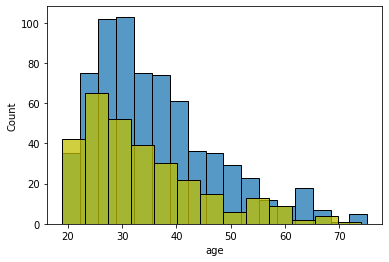

In [4]:
df_credit = pd.read_csv('german_credit_data.csv' , index_col=0)
def one_hot_encoder(df, nan_as_category = False):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category, drop_first=True)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

#Purpose to Dummies Variable
df_credit = df_credit.merge(pd.get_dummies(df_credit.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)

# Housing get dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df_credit = df_credit.merge(pd.get_dummies(df_credit["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df_credit = df_credit.merge(pd.get_dummies(df_credit.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df_credit = df_credit.merge(pd.get_dummies(df_credit["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
#Sex feature in dummies
df_credit = df_credit.merge(pd.get_dummies(df_credit.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)

df_credit['Credit amount'] = np.log(df_credit['Credit amount'])


#Excluding the missing columns
del df_credit["Saving accounts"]
del df_credit["Checking account"]
del df_credit["Purpose"]
del df_credit["Sex"]
del df_credit["Housing"]
del df_credit["Risk"]
del df_credit['Risk_bad']

x = pd.Series(df_credit[df_credit['Risk_good'] == 1]['Age'], name="age")
sns.histplot(x)
x = pd.Series(df_credit[df_credit['Risk_good'] == 0]['Age'], name="age")
sns.histplot(x, color='y')

In [5]:
interval = (18, 25, 120)

cats = ['young', 'old']
df_credit["Age_cat"] = pd.cut(df_credit.Age, interval, labels=cats)
# Housing get Age categorical
df_credit = df_credit.merge(pd.get_dummies(df_credit["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)
del df_credit['Age_cat']
del df_credit['Age']

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model

from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [7]:
df_credit.columns

Index(['Job', 'Credit amount', 'Duration', 'Purpose_car',
       'Purpose_domestic appliances', 'Purpose_education',
       'Purpose_furniture/equipment', 'Purpose_radio/TV', 'Purpose_repairs',
       'Purpose_vacation/others', 'Housing_own', 'Housing_rent',
       'Savings_moderate', 'Savings_no_inf', 'Savings_quite rich',
       'Savings_rich', 'Risk_good', 'Check_moderate', 'Check_no_inf',
       'Check_rich', 'Sex_male', 'Age_cat_old'],
      dtype='object')

In [8]:
df_credit_copy = copy.copy(df_credit)

(750, 19)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.882764 (0.059865)
KNN: 0.838377 (0.052544)


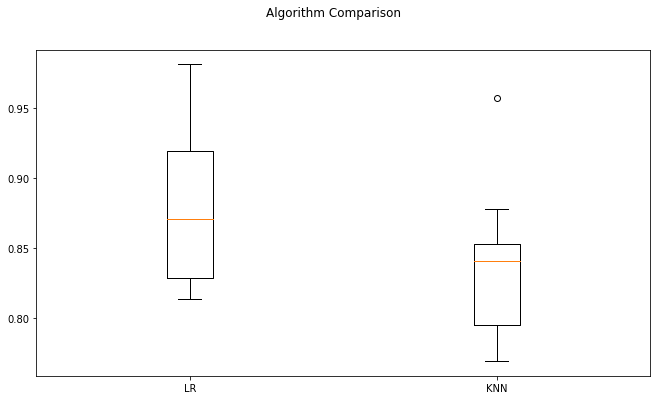

In [9]:
X = df_credit_copy.drop('Risk_good', axis=1).values
y = df_credit_copy['Risk_good'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

#############################
## DELETING AGE AND GENDER ##
##                         ##
#############################

X_train = np.delete(X_train, [-2, -1 ], 1)  
print(X_train.shape)
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [10]:
X_train.shape

(750, 19)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


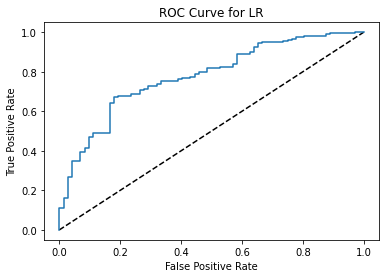

0.7771535580524344

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

name, model = models[0]
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for {}'.format(name))
plt.show()
roc_auc_score(y_test, y_pred_prob)

In [12]:
#anti_classification
import copy
y_pred_prob = model.predict(np.delete(X_test, [-2, -1], 1))
anti_class_X_test = copy.copy(X_test)


#Age
where_0 = np.where(anti_class_X_test[:,-1] == 0)
where_1 = np.where(anti_class_X_test[:,-1] == 1)

anti_class_X_test[where_0, -1] = 1
anti_class_X_test[where_1, -1] = 0

y_anti_class_prob = model.predict(np.delete(anti_class_X_test, [-2, -1], 1))
print('anti-class inconsistency for age: ',np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

#Gender
anti_class_X_test = copy.copy(X_test)
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)


# print(where_0)
anti_class_X_test[where_0, -2] = 1
anti_class_X_test[where_1, -2] = 0

y_anti_class_prob = model.predict(np.delete(anti_class_X_test, [-2, -1], 1))
print('anti-class inconsistency for gender: ', np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0


In [13]:
# Group Fairness
y_pred_prob = model.predict(np.delete(X_test, [-2, -1], 1))
Total_entries = X_test.shape[0]

#Age group
where_0 = np.where(anti_class_X_test[:,-1] == 0)
where_1 = np.where(anti_class_X_test[:,-1] == 1)

adult_count = len(where_0[0])
young_count = Total_entries - adult_count

adult_pred_positive = np.sum(y_pred_prob[where_0])
young_pred_positive = np.sum(y_pred_prob[where_1])

print('Group Fairness: Prob_adult = {} , Prob_young = {}'.format(adult_pred_positive/adult_count, young_pred_positive/young_count))


#Gender
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)

male_count = len(where_0[0])
female_count = Total_entries - male_count 

male_pred_positive = np.sum(y_pred_prob[where_0])
female_pred_positive = np.sum(y_pred_prob[where_1])

print('Group Fairness: Prob_male = {} , Prob_female = {}'.format(male_pred_positive/male_count, female_pred_positive/female_count))

Group Fairness: Prob_adult = 0.7058823529411765 , Prob_young = 0.8391959798994975
Group Fairness: Prob_male = 0.807909604519774 , Prob_female = 0.821917808219178


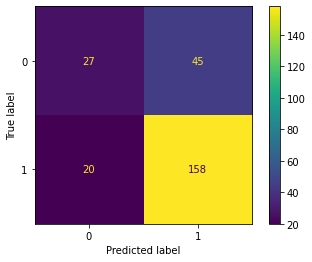

In [14]:
#separation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_prob = model.predict(np.delete(X_test, [-2, -1], 1))
cm = confusion_matrix(y_test, y_pred_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [15]:
#Gender
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)

male_pred = y_pred_prob[where_0]
male_label = y_test[where_0]
cm_male = confusion_matrix(male_label, male_pred)

female_pred = y_pred_prob[where_1]
female_label = y_test[where_1]
cm_female = confusion_matrix(female_label, female_pred)

print('Separation for FPR: male-> {}, female-> {}'.format( cm_male[0][1]/(cm_male[0][0] + cm_male[0][1]),  cm_female[0][1]/(cm_female[0][0] + cm_female[0][1]) ))
print('Separation for FNR: male-> {}, female-> {}'.format( cm_male[1][0]/(cm_male[1][0] + cm_male[1][1]),  cm_female[1][0]/(cm_female[1][0] + cm_female[1][1]) ))

Separation for FPR: male-> 0.62, female-> 0.6363636363636364
Separation for FNR: male-> 0.11811023622047244, female-> 0.09803921568627451


In [16]:
#Age
where_0 = np.where(anti_class_X_test[:,-1] == 1)
where_1 = np.where(anti_class_X_test[:,-1] == 0)

adult_pred = y_pred_prob[where_0]
adult_label = y_test[where_0]
cm_adult = confusion_matrix(adult_label, adult_pred)

young_pred = y_pred_prob[where_1]
young_label = y_test[where_1]
cm_young = confusion_matrix(young_label, young_pred)

print('Separation for FPR: adult-> {}, young-> {}'.format( cm_adult[0][1]/(cm_adult[0][0] + cm_adult[0][1]),  cm_young[0][1]/(cm_young[0][0] + cm_young[0][1]) ))
print('Separation for FNR: adult-> {}, young-> {}'.format( cm_adult[1][0]/(cm_adult[1][0] + cm_adult[1][1]),  cm_young[1][0]/(cm_young[1][0] + cm_young[1][1]) ))

Separation for FPR: adult-> 0.6545454545454545, young-> 0.5294117647058824
Separation for FNR: adult-> 0.09027777777777778, young-> 0.20588235294117646


In [17]:
#######################
#######################
## Changing Threshold##
#######################
#######################

In [18]:
df_credit_copy_thresh = copy.copy(df_credit)

(750, 19)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.882764 (0.059865)
KNN: 0.838377 (0.052544)


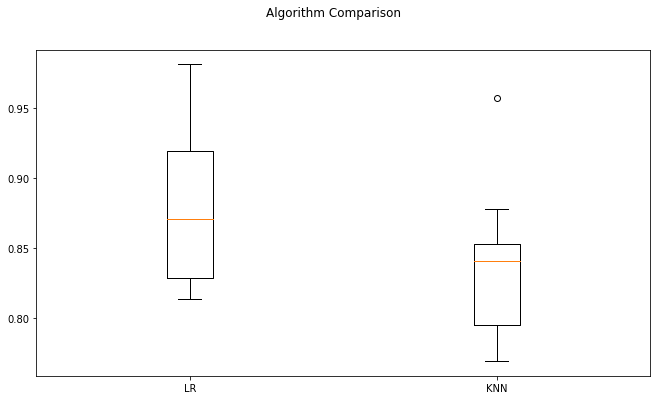

In [19]:
X = df_credit_copy_thresh.drop('Risk_good', axis=1).values
y = df_credit_copy_thresh['Risk_good'].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

#############################
## DELETING AGE AND GENDER ##
##                         ##
#############################

X_train = np.delete(X_train, [-2, -1 ], 1)  
print(X_train.shape)
# to feed the random state
seed = 7

# prepare models
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [20]:
X_train.shape

(750, 19)

In [39]:
thresh = 0.3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


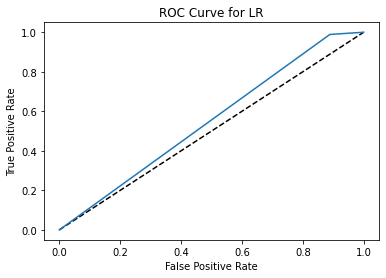

0.5499375780274657

In [40]:
from sklearn.metrics import roc_curve, roc_auc_score

name, model = models[0]
model.fit(X_train, y_train)
y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
# y_pred_prob = model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for {}'.format(name))
plt.show()
roc_auc_score(y_test, y_pred_prob)

In [37]:
#anti_classification
import copy
y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
anti_class_X_test = copy.copy(X_test)


#Age
where_0 = np.where(anti_class_X_test[:,-1] == 0)
where_1 = np.where(anti_class_X_test[:,-1] == 1)

anti_class_X_test[where_0, -1] = 1
anti_class_X_test[where_1, -1] = 0

y_anti_class_prob = model.predict(np.delete(anti_class_X_test, [-2, -1], 1))
print('anti-class inconsistency for age: ',np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

#Gender
anti_class_X_test = copy.copy(X_test)
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)


# print(where_0)
anti_class_X_test[where_0, -2] = 1
anti_class_X_test[where_1, -2] = 0

y_anti_class_prob = model.predict(np.delete(anti_class_X_test, [-2, -1], 1))
print('anti-class inconsistency for gender: ', np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0


In [38]:
# Group Fairness
y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
Total_entries = X_test.shape[0]

#Age group
where_0 = np.where(anti_class_X_test[:,-1] == 0)
where_1 = np.where(anti_class_X_test[:,-1] == 1)

adult_count = len(where_0[0])
young_count = Total_entries - adult_count

adult_pred_positive = np.sum(y_pred_prob[where_0])
young_pred_positive = np.sum(y_pred_prob[where_1])

print('Group Fairness: Prob_adult = {} , Prob_young = {}'.format(adult_pred_positive/adult_count, young_pred_positive/young_count))


#Gender
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)

male_count = len(where_0[0])
female_count = Total_entries - male_count 

male_pred_positive = np.sum(y_pred_prob[where_0])
female_pred_positive = np.sum(y_pred_prob[where_1])

print('Group Fairness: Prob_male = {} , Prob_female = {}'.format(male_pred_positive/male_count, female_pred_positive/female_count))

Group Fairness: Prob_adult = 0.6666666666666666 , Prob_young = 0.7939698492462312
Group Fairness: Prob_male = 0.7627118644067796 , Prob_female = 0.7808219178082192


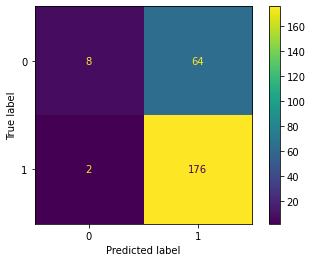

In [25]:
#separation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
cm = confusion_matrix(y_test, y_pred_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [26]:
#Gender
where_0 = np.where(anti_class_X_test[:,-2] == 0)
where_1 = np.where(anti_class_X_test[:,-2] == 1)

male_pred = y_pred_prob[where_0]
male_label = y_test[where_0]
cm_male = confusion_matrix(male_label, male_pred)

female_pred = y_pred_prob[where_1]
female_label = y_test[where_1]
cm_female = confusion_matrix(female_label, female_pred)

print('Separation for FPR: male-> {}, female-> {}'.format( cm_male[0][1]/(cm_male[0][0] + cm_male[0][1]),  cm_female[0][1]/(cm_female[0][0] + cm_female[0][1]) ))
print('Separation for FNR: male-> {}, female-> {}'.format( cm_male[1][0]/(cm_male[1][0] + cm_male[1][1]),  cm_female[1][0]/(cm_female[1][0] + cm_female[1][1]) ))

Separation for FPR: male-> 0.88, female-> 0.9090909090909091
Separation for FNR: male-> 0.015748031496062992, female-> 0.0


In [27]:
#Age
where_0 = np.where(anti_class_X_test[:,-1] == 1)
where_1 = np.where(anti_class_X_test[:,-1] == 0)

adult_pred = y_pred_prob[where_0]
adult_label = y_test[where_0]
cm_adult = confusion_matrix(adult_label, adult_pred)

young_pred = y_pred_prob[where_1]
young_label = y_test[where_1]
cm_young = confusion_matrix(young_label, young_pred)

print('Separation for FPR: adult-> {}, young-> {}'.format( cm_adult[0][1]/(cm_adult[0][0] + cm_adult[0][1]),  cm_young[0][1]/(cm_young[0][0] + cm_young[0][1]) ))
print('Separation for FNR: adult-> {}, young-> {}'.format( cm_adult[1][0]/(cm_adult[1][0] + cm_adult[1][1]),  cm_young[1][0]/(cm_young[1][0] + cm_young[1][1]) ))

Separation for FPR: adult-> 0.8909090909090909, young-> 0.8823529411764706
Separation for FNR: adult-> 0.013888888888888888, young-> 0.0


Running a series of experiments for different threshold values 

Threshold : 0.1 



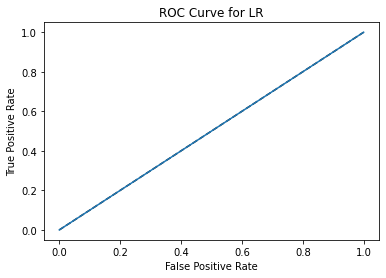

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  47
anti-class inconsistency for gender:  47
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 1.0 , Prob_young = 1.0
Group Fairness: Prob_male = 1.0 , Prob_female = 1.0

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 1.0, female-> 1.0
Separation for FNR: male-> 0.0, female-> 0.0
Separation for FPR: adult-> 1.0, young-> 1.0
Separation for FNR: adult-> 0.0, young-> 0.0
End of experiment for threshold = 0.1 


Threshold : 0.2 



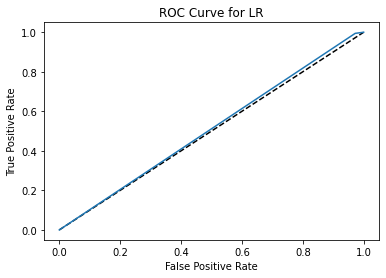

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  44
anti-class inconsistency for gender:  44
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 1.0 , Prob_young = 0.9849246231155779
Group Fairness: Prob_male = 0.9830508474576272 , Prob_female = 1.0

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.96, female-> 1.0
Separation for FNR: male-> 0.007874015748031496, female-> 0.0
Separation for FPR: adult-> 0.9636363636363636, young-> 1.0
Separation for FNR: adult-> 0.006944444444444444, young-> 0.0
End of experiment for threshold = 0.2 


Threshold : 0.3 



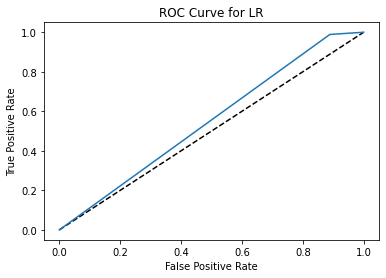

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  37
anti-class inconsistency for gender:  37
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.9607843137254902 , Prob_young = 0.9597989949748744
Group Fairness: Prob_male = 0.9548022598870056 , Prob_female = 0.9726027397260274

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.88, female-> 0.9090909090909091
Separation for FNR: male-> 0.015748031496062992, female-> 0.0
Separation for FPR: adult-> 0.8909090909090909, young-> 0.8823529411764706
Separation for FNR: adult-> 0.013888888888888888, young-> 0.0
End of experiment for threshold = 0.3 


Threshold : 0.4 



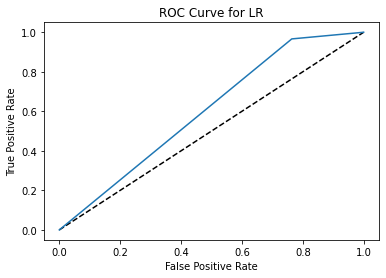

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  24
anti-class inconsistency for gender:  24
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.8627450980392157 , Prob_young = 0.9195979899497487
Group Fairness: Prob_male = 0.903954802259887 , Prob_female = 0.9178082191780822

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.74, female-> 0.8181818181818182
Separation for FNR: male-> 0.031496062992125984, female-> 0.0392156862745098
Separation for FPR: adult-> 0.8, young-> 0.6470588235294118
Separation for FNR: adult-> 0.034722222222222224, young-> 0.029411764705882353
End of experiment for threshold = 0.4 


Threshold : 0.5 



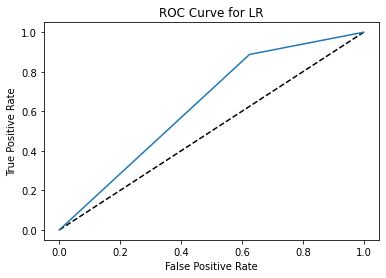

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.7058823529411765 , Prob_young = 0.8391959798994975
Group Fairness: Prob_male = 0.807909604519774 , Prob_female = 0.821917808219178

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.62, female-> 0.6363636363636364
Separation for FNR: male-> 0.11811023622047244, female-> 0.09803921568627451
Separation for FPR: adult-> 0.6545454545454545, young-> 0.5294117647058824
Separation for FNR: adult-> 0.09027777777777778, young-> 0.20588235294117646
End of experiment for threshold = 0.5 


Threshold : 0.6 



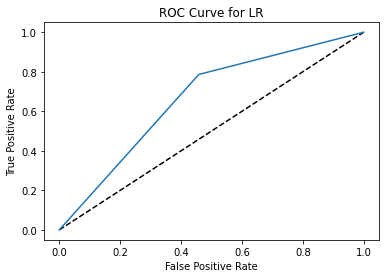

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.5882352941176471 , Prob_young = 0.7185929648241206
Group Fairness: Prob_male = 0.672316384180791 , Prob_female = 0.7397260273972602

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.4, female-> 0.5909090909090909
Separation for FNR: male-> 0.2204724409448819, female-> 0.19607843137254902
Separation for FPR: adult-> 0.4727272727272727, young-> 0.4117647058823529
Separation for FNR: adult-> 0.1875, young-> 0.3235294117647059
End of experiment for threshold = 0.6 


Threshold : 0.7 



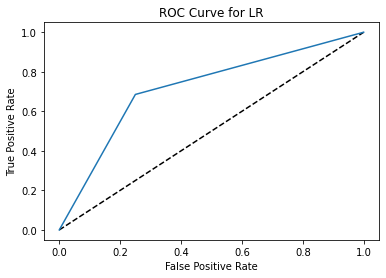

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.47058823529411764 , Prob_young = 0.5829145728643216
Group Fairness: Prob_male = 0.536723163841808 , Prob_female = 0.6164383561643836

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.2, female-> 0.36363636363636365
Separation for FNR: male-> 0.33070866141732286, female-> 0.27450980392156865
Separation for FPR: adult-> 0.3090909090909091, young-> 0.058823529411764705
Separation for FNR: adult-> 0.3125, young-> 0.3235294117647059
End of experiment for threshold = 0.7 


Threshold : 0.8 



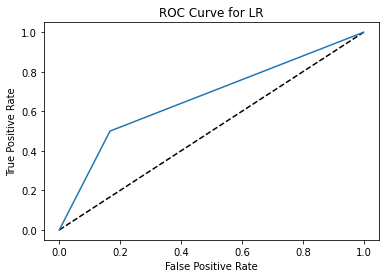

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.3137254901960784 , Prob_young = 0.4271356783919598
Group Fairness: Prob_male = 0.384180790960452 , Prob_female = 0.4520547945205479

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.14, female-> 0.22727272727272727
Separation for FNR: male-> 0.5196850393700787, female-> 0.45098039215686275
Separation for FPR: adult-> 0.2, young-> 0.058823529411764705
Separation for FNR: adult-> 0.4861111111111111, young-> 0.5588235294117647
End of experiment for threshold = 0.8 


Threshold : 0.9 



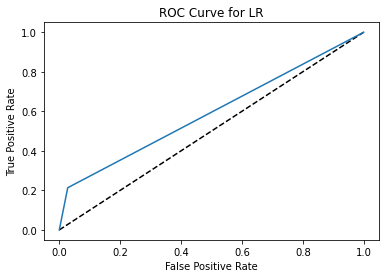

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.0392156862745098 , Prob_young = 0.19095477386934673
Group Fairness: Prob_male = 0.15254237288135594 , Prob_female = 0.1780821917808219

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.02, female-> 0.045454545454545456
Separation for FNR: male-> 0.7952755905511811, female-> 0.7647058823529411
Separation for FPR: adult-> 0.03636363636363636, young-> 0.0
Separation for FNR: adult-> 0.75, young-> 0.9411764705882353
End of experiment for threshold = 0.9 


Threshold : 1.0 



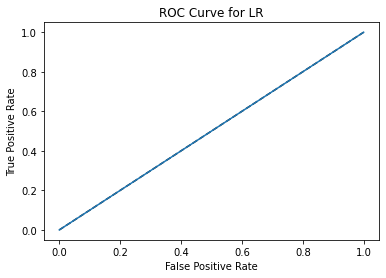

Evaluating Anti-classification for Age and Gender 

anti-class inconsistency for age:  0
anti-class inconsistency for gender:  0
Evaluating Group Fairness for Age and Gender 

Group Fairness: Prob_adult = 0.0 , Prob_young = 0.0
Group Fairness: Prob_male = 0.0 , Prob_female = 0.0

Evaluating Separation for Age and Gender 

Separation for FPR: male-> 0.0, female-> 0.0
Separation for FNR: male-> 1.0, female-> 1.0
Separation for FPR: adult-> 0.0, young-> 0.0
Separation for FNR: adult-> 1.0, young-> 1.0
End of experiment for threshold = 1.0 




In [51]:
from warnings import filterwarnings
filterwarnings('ignore')

thresh_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
print("Running a series of experiments for different threshold values \n")
for thresh in thresh_list:
  print("Threshold : {} \n".format(thresh))
  name, model = models[0]
  model.fit(X_train, y_train)
  y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for {}'.format(name))
  plt.show()
  roc_auc_score(y_test, y_pred_prob)

  #anti_classification
  import copy
  y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
  anti_class_X_test = copy.copy(X_test)

  print("Evaluating Anti-classification for Age and Gender \n")

  #Age
  where_0 = np.where(anti_class_X_test[:,-1] == 0)
  where_1 = np.where(anti_class_X_test[:,-1] == 1)

  anti_class_X_test[where_0, -1] = 1
  anti_class_X_test[where_1, -1] = 0

  y_anti_class_prob = model.predict(np.delete(anti_class_X_test, [-2, -1], 1))
  print('anti-class inconsistency for age: ',np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

  #Gender
  anti_class_X_test = copy.copy(X_test)
  where_0 = np.where(anti_class_X_test[:,-2] == 0)
  where_1 = np.where(anti_class_X_test[:,-2] == 1)


  anti_class_X_test[where_0, -2] = 1
  anti_class_X_test[where_1, -2] = 0

  y_anti_class_prob = model.predict(np.delete(anti_class_X_test, [-2, -1], 1))
  print('anti-class inconsistency for gender: ', np.count_nonzero(np.abs(y_pred_prob - y_anti_class_prob) == 1))

  print("Evaluating Group Fairness for Age and Gender \n")
# Group Fairness
  y_pred_prob = (model.predict_proba(np.delete(X_test, [-2, -1], 1))[:,1] >= thresh).astype(bool) #
  Total_entries = X_test.shape[0]

  #Age group
  where_0 = np.where(anti_class_X_test[:,-1] == 0)
  where_1 = np.where(anti_class_X_test[:,-1] == 1)

  adult_count = len(where_0[0])
  young_count = Total_entries - adult_count

  adult_pred_positive = np.sum(y_pred_prob[where_0])
  young_pred_positive = np.sum(y_pred_prob[where_1])

  print('Group Fairness: Prob_adult = {} , Prob_young = {}'.format(adult_pred_positive/adult_count, young_pred_positive/young_count))


  #Gender
  where_0 = np.where(anti_class_X_test[:,-2] == 0)
  where_1 = np.where(anti_class_X_test[:,-2] == 1)

  male_count = len(where_0[0])
  female_count = Total_entries - male_count 

  male_pred_positive = np.sum(y_pred_prob[where_0])
  female_pred_positive = np.sum(y_pred_prob[where_1])

  print('Group Fairness: Prob_male = {} , Prob_female = {}'.format(male_pred_positive/male_count, female_pred_positive/female_count))

  print("\nEvaluating Separation for Age and Gender \n")
    #Gender
  where_0 = np.where(anti_class_X_test[:,-2] == 0)
  where_1 = np.where(anti_class_X_test[:,-2] == 1)

  male_pred = y_pred_prob[where_0]
  male_label = y_test[where_0]
  cm_male = confusion_matrix(male_label, male_pred)

  female_pred = y_pred_prob[where_1]
  female_label = y_test[where_1]
  cm_female = confusion_matrix(female_label, female_pred)

  print('Separation for FPR: male-> {}, female-> {}'.format( cm_male[0][1]/(cm_male[0][0] + cm_male[0][1]),  cm_female[0][1]/(cm_female[0][0] + cm_female[0][1]) ))
  print('Separation for FNR: male-> {}, female-> {}'.format( cm_male[1][0]/(cm_male[1][0] + cm_male[1][1]),  cm_female[1][0]/(cm_female[1][0] + cm_female[1][1]) ))


  #Age
  where_0 = np.where(anti_class_X_test[:,-1] == 1)
  where_1 = np.where(anti_class_X_test[:,-1] == 0)

  adult_pred = y_pred_prob[where_0]
  adult_label = y_test[where_0]
  cm_adult = confusion_matrix(adult_label, adult_pred)

  young_pred = y_pred_prob[where_1]
  young_label = y_test[where_1]
  cm_young = confusion_matrix(young_label, young_pred)

  print('Separation for FPR: adult-> {}, young-> {}'.format( cm_adult[0][1]/(cm_adult[0][0] + cm_adult[0][1]),  cm_young[0][1]/(cm_young[0][0] + cm_young[0][1]) ))
  print('Separation for FNR: adult-> {}, young-> {}'.format( cm_adult[1][0]/(cm_adult[1][0] + cm_adult[1][1]),  cm_young[1][0]/(cm_young[1][0] + cm_young[1][1]) ))

  print("End of experiment for threshold = {} \n\n".format(thresh))
